NY Rental Analysis

In [1]:
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

In [2]:
csv_file = os.path.join("NY Realstate Pricing.csv")
realestate_data_df = pd.read_csv(csv_file)

realestate_data_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [3]:
realestate_data_df["neighbourhood"].value_counts()

Brooklyn              3875
Manhattan             3229
Queens                1099
Bedford-Stuyvesant     799
Harlem                 632
                      ... 
Sea Gate                 1
Marble Hill              1
Midland Beach            1
Mill Basin               1
Van Nest                 1
Name: neighbourhood, Length: 186, dtype: int64

In [4]:
realestate_data_clean_df = realestate_data_df.dropna() 

realestate_data_clean_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [5]:
daysoccupied = realestate_data_clean_df.groupby(["room_type"])

daysoccupied_mean = daysoccupied["days_occupied_in_2019"].mean()
daysoccupied_median = daysoccupied["days_occupied_in_2019"].median()
daysoccupied_var = daysoccupied["days_occupied_in_2019"].var()
daysoccupied_std = daysoccupied["days_occupied_in_2019"].std()
daysoccupied_sem = daysoccupied["days_occupied_in_2019"].sem()

daysoccupied_df = pd.DataFrame({
                        "Mean": daysoccupied_mean,
                        "Median" : daysoccupied_median,
                        "Variance": daysoccupied_var,
                        "Standard Deviation": daysoccupied_std,
                        "SEM": daysoccupied_sem,
})

daysoccupied_df

,Mean,Median,Variance,Standard Deviation,SEM
room_type,,,,,
Entire home/apt,185.165231,200.0,16986.175375,130.331022,1.343904
Hotel room,83.500000,14.5,13106.878788,114.485278,11.448528
Private room,175.723297,198.0,16689.546055,129.188026,1.467288
Shared room,140.022409,83.0,17693.482642,133.016851,7.039998


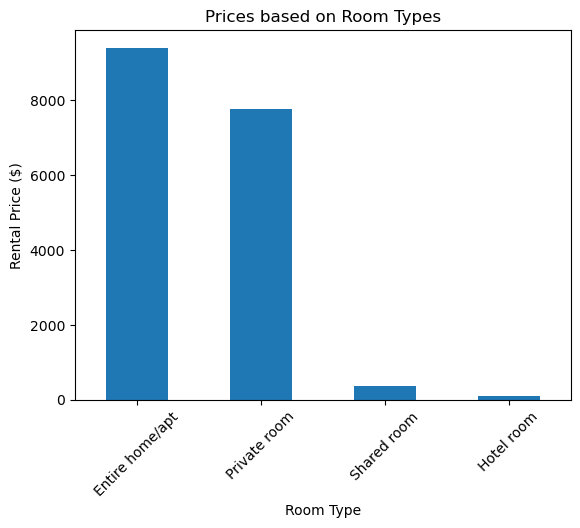

In [6]:
timepoint = realestate_data_df.groupby(["room_type"])["price"].count()
ax = timepoint.sort_values(ascending=False).plot.bar()
ax = timepoint.sort_values(ascending=False).plot.bar(align='center')

ax.set_title("Prices based on Room Types")
ax.set_xlabel("Room Type")
ax.set_ylabel("Rental Price ($)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig("output/Graph1.png")
plt.show()


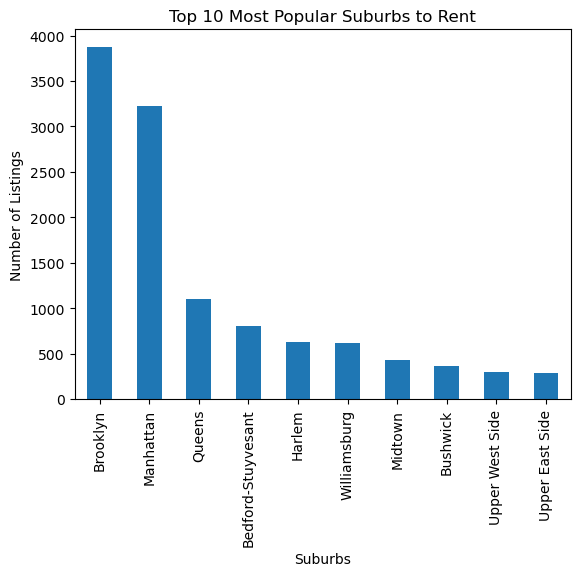

In [7]:
location_count = realestate_data_df['neighbourhood'].value_counts()
top_10_locations = location_count.nlargest(10)
ax = top_10_locations.plot(kind='bar')

ax.set_title("Top 10 Most Popular Suburbs to Rent")
ax.set_xlabel("Suburbs")
ax.set_ylabel("Number of Listings")

plt.savefig("output/Graph2.png")
plt.show()

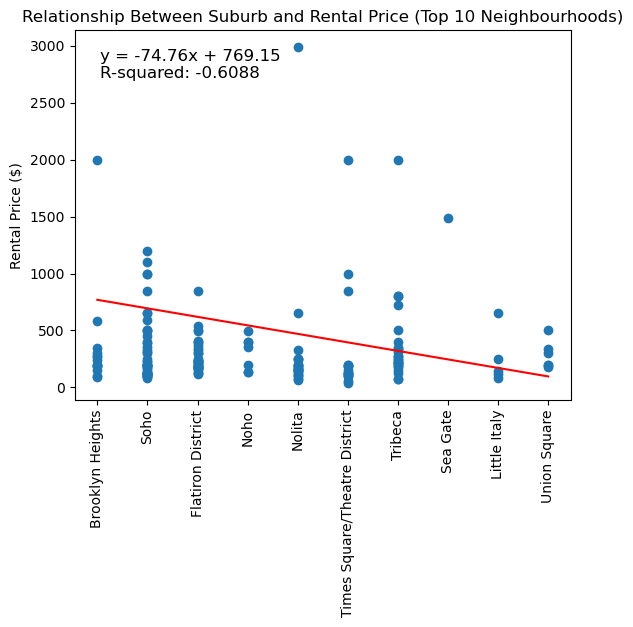

In [15]:
rent_and_suburb = realestate_data_df[["price", "neighbourhood"]]
mean_rent_by_suburb = rent_and_suburb.groupby('neighbourhood').mean()
top_10_neighborhoods = mean_rent_by_suburb.sort_values(by='price', ascending=False).head(10).index.tolist()

realestate_data_top10_df = realestate_data_df[realestate_data_df['neighbourhood'].isin(top_10_neighborhoods)]
plt.scatter(realestate_data_top10_df['neighbourhood'], realestate_data_top10_df['price'])

x = np.arange(len(top_10_neighborhoods))
y = mean_rent_by_suburb.loc[top_10_neighborhoods]['price']
m, b, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, m*x + b, color='red')

plt.title("Relationship Between Suburb and Rental Price (Top 10 Neighbourhoods)")
plt.ylabel("Rental Price ($)")

plt.xticks(rotation=90)

plt.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\nR-squared: {r_value:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
plt.savefig("output/Scatter1.png")
plt.show()


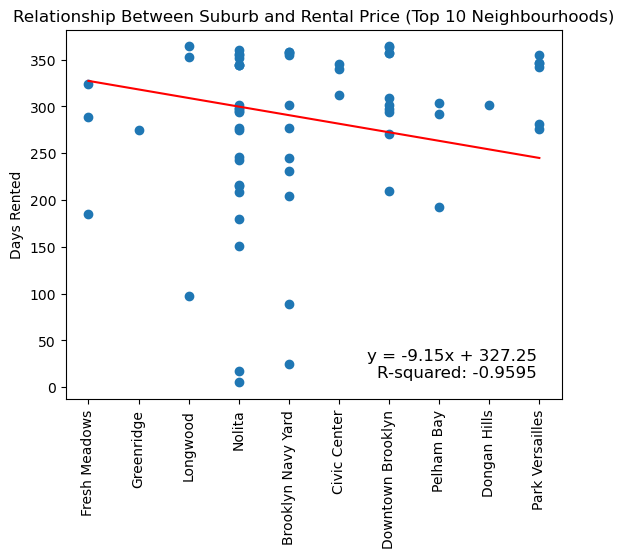

In [29]:
rent_and_suburb = realestate_data_df[["days_occupied_in_2019", "neighbourhood"]]
mean_rent_by_suburb = rent_and_suburb.groupby('neighbourhood').mean()
top_10_neighborhoods = mean_rent_by_suburb.sort_values(by="days_occupied_in_2019", ascending=False).head(10).index.tolist()

realestate_data_top10_df = realestate_data_df[realestate_data_df['neighbourhood'].isin(top_10_neighborhoods)]
plt.scatter(realestate_data_top10_df['neighbourhood'], realestate_data_top10_df["days_occupied_in_2019"])

x = np.arange(len(top_10_neighborhoods))
y = mean_rent_by_suburb.loc[top_10_neighborhoods]["days_occupied_in_2019"]
m, b, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, m*x + b, color='red')

plt.title("Relationship Between Suburb and Rental Price (Top 10 Neighbourhoods)")
plt.ylabel("Days Rented")

plt.xticks(rotation=90)

plt.text(0.95, 0.05, f'y = {m:.2f}x + {b:.2f}\nR-squared: {r_value:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.savefig("output/Scatter2.png")
plt.show()

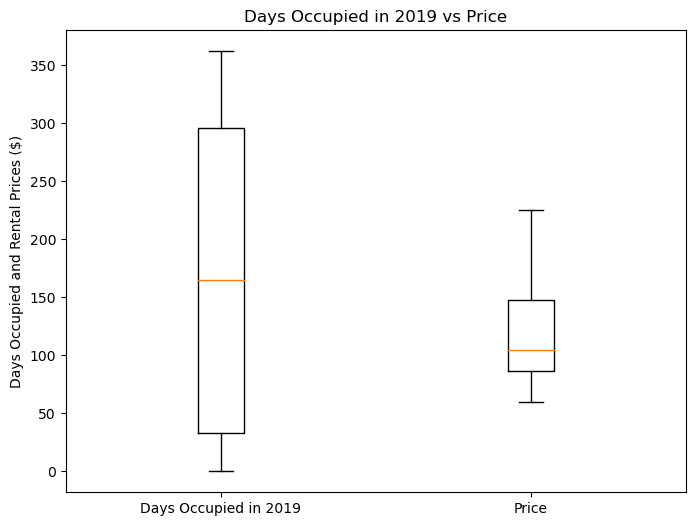

In [30]:
days_occupied_2019 = realestate_data_df["days_occupied_in_2019"].tolist()
prices = realestate_data_df['price'].tolist()

fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([days_occupied_2019[:10], prices[:10]], labels=['Days Occupied in 2019', 'Price'], showfliers=True)

ax.set_title('Days Occupied in 2019 vs Price')
ax.set_ylabel('Days Occupied and Rental Prices ($)')

plt.savefig("output/Boxplot1.png")
plt.show()